In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import datetime, timedelta
from tqdm import tqdm
%cd ..
from graphs import generate_full_report, perform_profit_factor_permutation_test
from utils import MARKET_TZ, is_market_open, calculate_profit_factor
%cd 1m_first

f:\Coding\Trading
f:\Coding\Trading\1m_first


In [2]:
def calculate_vwap(data):
    """
    Calculate intraday VWAP for each day.
    VWAP = cumulative (Typical Price * Volume) / cumulative Volume for the day
    """
    data = data.copy()
    data['Date'] = data.index.date
    data[['High', 'Low', 'Close', 'Volume']] = data[['High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    data['TPV'] = typical_price * data['Volume']
    data['Cumul_TPV'] = data.groupby('Date')['TPV'].cumsum()
    data['Cumul_Vol'] = data.groupby('Date')['Volume'].cumsum()
    data['VWAP'] = data['Cumul_TPV'] / data['Cumul_Vol']
    return data

def calculate_rsi(data, period=14):
    """Calculate RSI with protection against division by zero."""
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    avg_loss = avg_loss.replace(0, np.finfo(float).eps)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def apply_strategy(data):
    """Apply the HedgeScalp strategy with improved implementation."""
    if len(data) < 20:
        return pd.DataFrame()
        
    data = calculate_vwap(data)
    data['RSI'] = calculate_rsi(data, period=14)
    data['Vol_MA'] = data['Volume'].rolling(window=20, min_periods=20).mean()
    
    threshold = 0.003
    
    data['ShortSignal'] = (data['Close'] > data['VWAP'] * (1 + threshold)) & \
                          (data['RSI'] > 70) & \
                          (data['Volume'] < data['Vol_MA'] * 0.75)
                          
    data['LongSignal'] = (data['Close'] < data['VWAP'] * (1 - threshold)) & \
                         (data['RSI'] < 30) & \
                         (data['Volume'] < data['Vol_MA'] * 0.75)
    
    data['Signal'] = 0
    data.loc[data['LongSignal'], 'Signal'] = 1
    data.loc[data['ShortSignal'], 'Signal'] = -1
    
    return data

In [3]:
def get_historical_data(ticker, start_date, end_date):
    """
    Retrieve historical data from local storage or download new data and append.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    # Convert input dates to timezone-aware datetime objects
    start_date = pd.to_datetime(start_date).tz_localize(MARKET_TZ)
    end_date = pd.to_datetime(end_date).tz_localize(MARKET_TZ)
    
    try:
        # Load existing data if available
        if os.path.exists(file_path):
            existing_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
            existing_data.index = existing_data.index.tz_localize(MARKET_TZ)
            last_date = existing_data.index.max()
        else:
            existing_data = pd.DataFrame()
            last_date = None
        
        # Determine date range needed
        download_start = last_date + timedelta(minutes=1) if last_date else start_date
        download_end = end_date
        
        # Only download if needed
        if not last_date or download_start < download_end:
            # Download new data
            new_data = yf.download(ticker, 
                                 start=download_start.tz_localize(None), 
                                 end=download_end.tz_localize(None),
                                 interval='1m')
            
            if not new_data.empty:
                # If data has multiple column levels, reduce to a single level.
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                # Convert index to market timezone
                new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                # Combine with existing data
                combined_data = pd.concat([existing_data, new_data])
                # Remove duplicates keeping last entry
                combined_data = combined_data[~combined_data.index.duplicated(keep='last')]
                combined_data.sort_index(inplace=True)
                
                # Save with naive timestamp
                combined_data_naive = combined_data.copy()
                combined_data_naive.index = combined_data_naive.index.tz_localize(None)
                combined_data_naive.to_csv(file_path)
            else:
                combined_data = existing_data
        else:
            combined_data = existing_data
        
        # Filter for requested date range
        filtered_data = combined_data.loc[start_date:end_date]
        return filtered_data
    
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

In [4]:
def run_backtest(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run a backtest of the HedgeScalp strategy on multiple stocks
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all trades and performance metrics
    """
    all_trades = []
    trade_logs = {}
    
    pbar = tqdm(tickers, desc="Processing Stocks")
    for ticker in pbar:
        pbar.set_description(f"Processing {ticker}")
        try:
            data = get_historical_data(ticker, start_date, end_date)
            if data.empty:
                continue
            
            # Apply HedgeScalp strategy to generate signals.
            data = apply_strategy(data)
            
            # Skip if no signals were generated.
            if 'Signal' not in data.columns or data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day
            for day, day_data in data.groupby(data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if t not in active_trades and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Stop': initial_stop,
                            'RSI': row['RSI'],
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
                        
                        # print(f"{direction} {ticker} at {row['Close']:.2f} on {t} (RSI: {row['RSI']:.2f}, VWAP: {vwap:.2f})")
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall results
            all_trades.extend(ticker_trades)
            
            # Store in trade logs for performance summary
            if ticker_trades:
                trade_logs[ticker] = [t['Return'] for t in ticker_trades]
                
                # Print performance for this ticker
                total_pnl = sum(trade_logs[ticker])
                num_trades = len(trade_logs[ticker])
                # print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades")
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe 
    if all_trades:
        results = pd.DataFrame(all_trades)
        results.sort_values('DateTime', inplace=True)
        
        # Print overall performance summary
        print("\n=== Overall Performance Summary ===")
        print(f"Total Return: {results['Return'].sum():.4f} ({results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {results['Return'].mean():.4f} ({results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {(results['Return'] > 0).mean():.2%}")
        print(f"Total Number of Trades: {len(results)}")
        
        # Print per-stock summary
        print("\n=== Per-stock Trade Performance Summary ===")
        for symbol, pnl_list in trade_logs.items():
            total_pnl = sum(pnl_list)
            num_trades = len(pnl_list)
            win_rate = sum(1 for pnl in pnl_list if pnl > 0) / num_trades if num_trades > 0 else 0
            print(f"{symbol}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%})")
        
        return results
    else:
        print("No trades were generated.")
        return pd.DataFrame()

In [5]:
tickers = [
    "MSTR", "COIN", "RIVN", "CVNA", "PLTR", "DJT", "AMD", "MRNA", "DKNG", "SNAP",
    "MARA", "RIOT", "KMX", "CLSK", "CORZ", "HUT", "CZR", "NVDA", "AVGO",
]

# Run the backtest
today = datetime.now().date()
if not is_market_open(today):
    print(f"Market is closed ({today}). Adjusting to last trading day.")
    end_date = (datetime.now() - BDay(1))
    start_date = (end_date - timedelta(days=7))
else:
    end_date = datetime.now()
    start_date = (end_date - timedelta(days=7))

results = run_backtest(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=5
)

Processing MSTR:   0%|          | 0/19 [00:00<?, ?it/s]  

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing SNAP:  47%|████▋     | 9/19 [00:03<00:03,  3.06it/s]

Error processing DKNG: Timestamp('2025-09-11 12:02:00-0400', tz='US/Eastern')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing AVGO: 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


=== Overall Performance Summary ===
Total Return: 1.5778 (157.78%)
Average Return per Trade: 0.0010 (0.10%)
Win Rate: 74.00%
Total Number of Trades: 1581

=== Per-stock Trade Performance Summary ===
MSTR: Total PnL: 0.0794 from 71 trades (Win rate: 80.28%)
COIN: Total PnL: 0.0227 from 59 trades (Win rate: 62.71%)
RIVN: Total PnL: 0.1162 from 131 trades (Win rate: 70.99%)
CVNA: Total PnL: 0.0829 from 102 trades (Win rate: 72.55%)
PLTR: Total PnL: 0.0213 from 37 trades (Win rate: 81.08%)
DJT: Total PnL: 0.0610 from 95 trades (Win rate: 71.58%)
AMD: Total PnL: 0.0364 from 63 trades (Win rate: 71.43%)
MRNA: Total PnL: 0.1624 from 98 trades (Win rate: 78.57%)
SNAP: Total PnL: 0.1069 from 101 trades (Win rate: 68.32%)
MARA: Total PnL: 0.1500 from 99 trades (Win rate: 76.77%)
RIOT: Total PnL: 0.0943 from 74 trades (Win rate: 74.32%)
KMX: Total PnL: 0.1534 from 158 trades (Win rate: 83.54%)
CLSK: Total PnL: 0.1255 from 86 trades (Win rate: 73.26%)
CORZ: Total PnL: 0.1059 from 125 trades (Win 

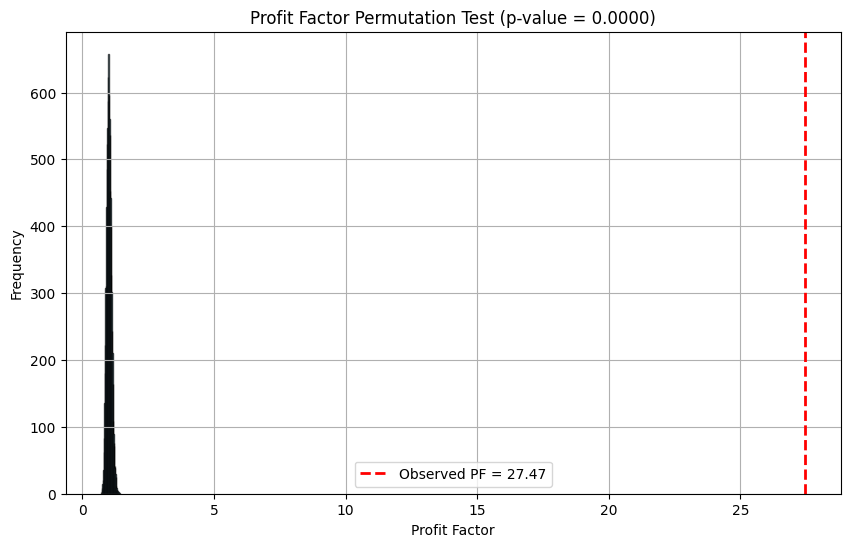


=== Profit Factor Permutation Test ===
Observed Profit Factor: 27.4687
Mean Permutation Profit Factor: 1.0040
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)

Profit Factor Permutation Test p-value: 0.0000
Result: Statistically significant profit factor (p < 0.05)


In [6]:
# Extract returns array
returns_array = results['Return'].values

# Run permutation test (e.g., 10,000 permutations)
p_value = perform_profit_factor_permutation_test(returns_array, n_permutations=10000)

# Display p-value
print(f"\nProfit Factor Permutation Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant profit factor (p < 0.05)")
else:
    print("Result: Profit factor not statistically significant (p >= 0.05)")


PERFORMANCE REPORT


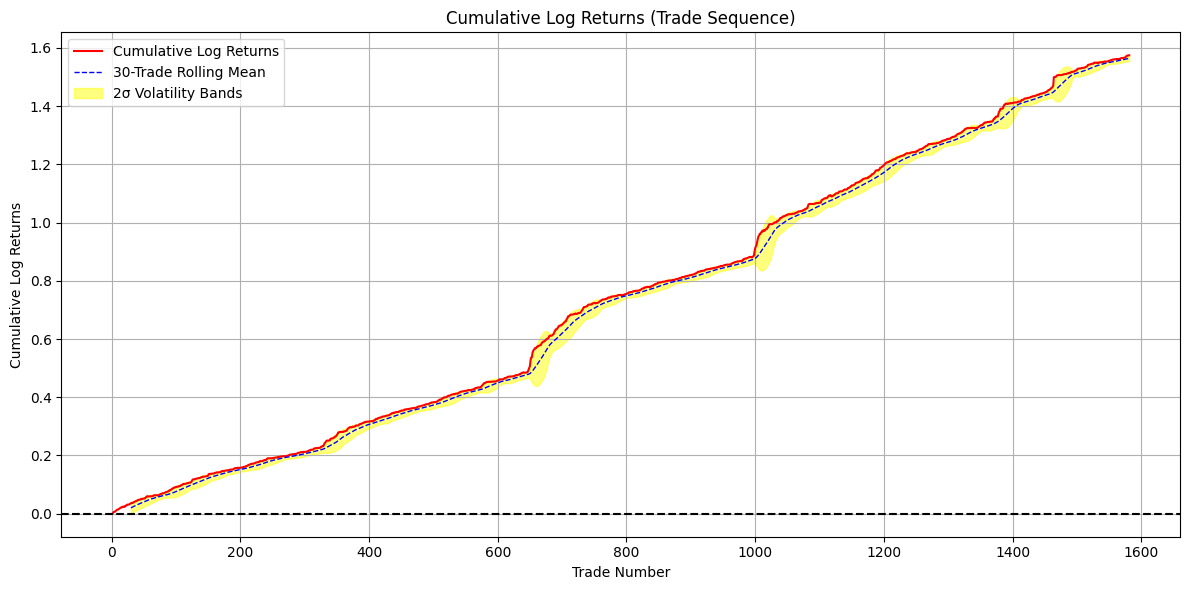

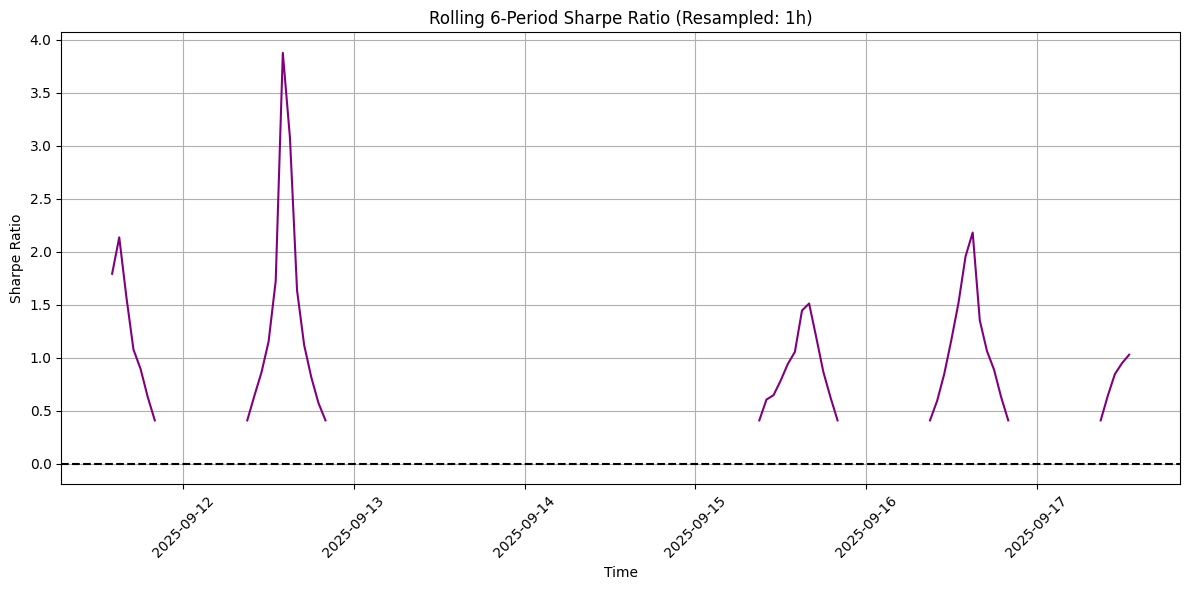

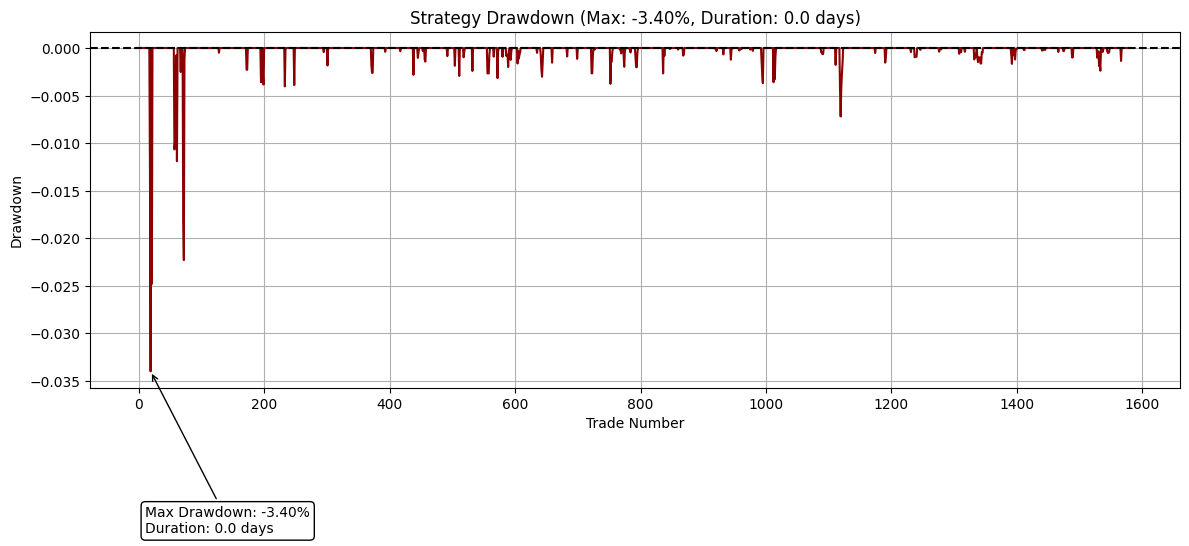


--- Return Statistics ---
count    1581.0000
mean        0.0010
std         0.0017
min        -0.0029
10%         0.0000
25%         0.0000
50%         0.0006
75%         0.0014
90%         0.0026
99%         0.0071
99.9%       0.0170
99.99%      0.0288
max         0.0306

--- Worst Outcomes (Bottom 1.0%) ---
Worst 1.0000%: -0.0009
Worst 0.1000%: -0.0021
Worst 0.0100%: -0.0028


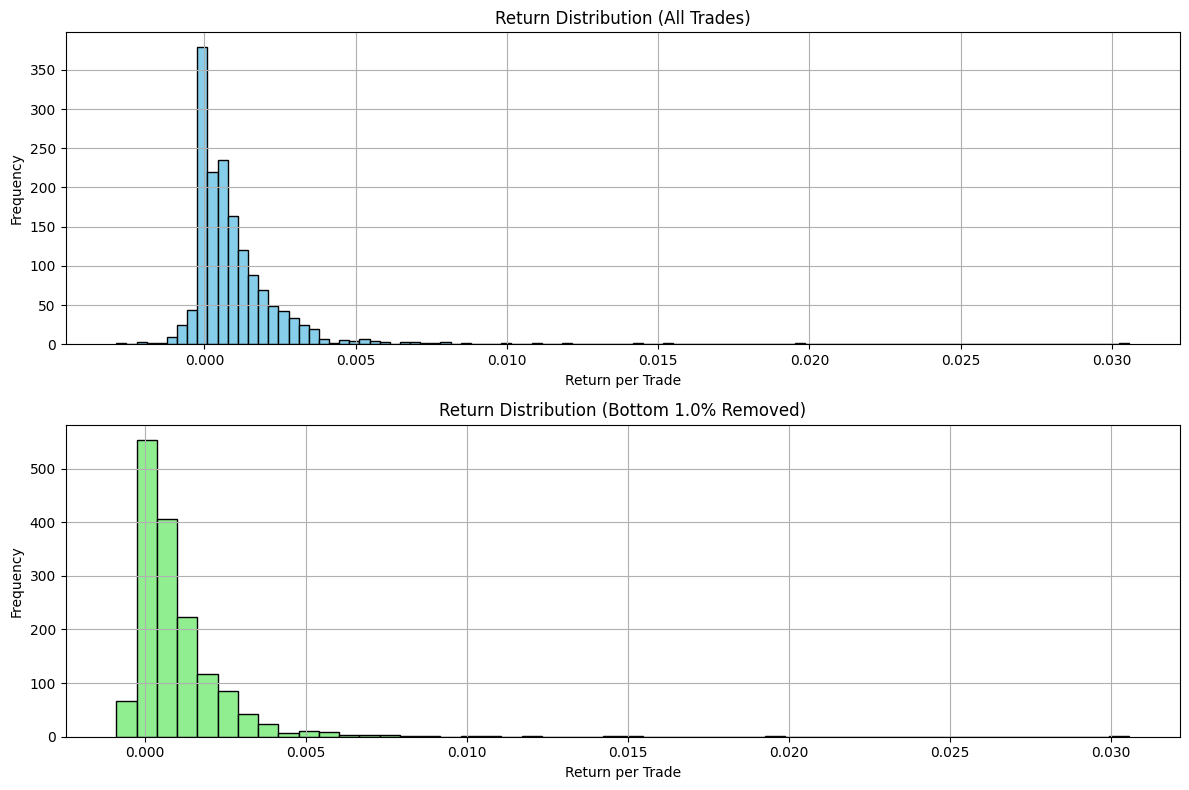

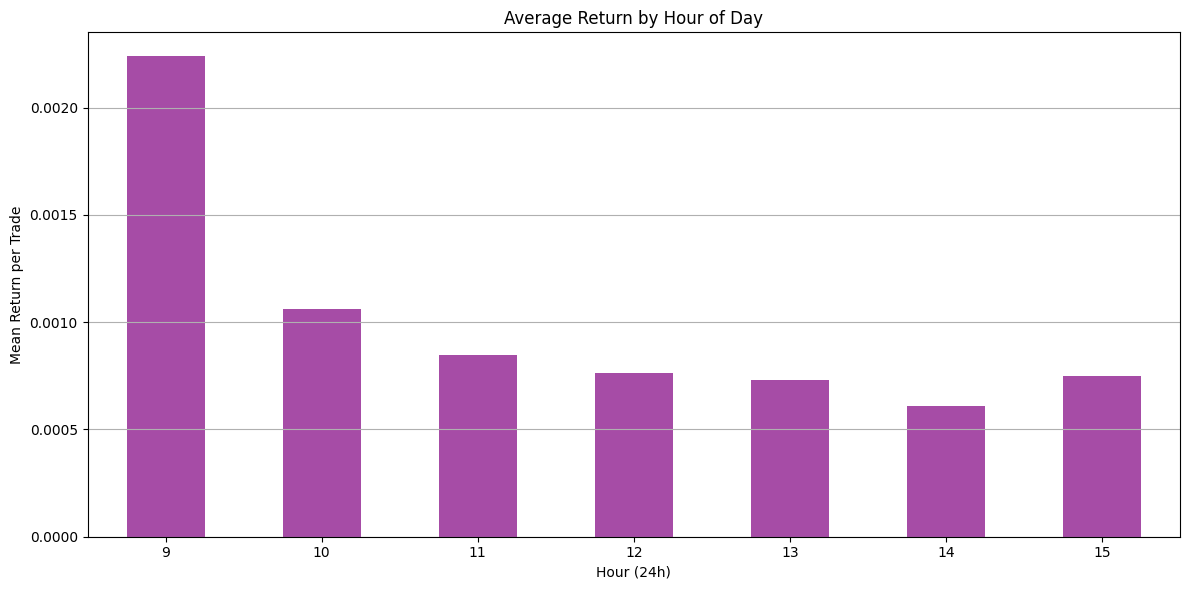


--- 1 Day Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    1381.44
std       52.46
min     1236.96
1%      1282.09
10%     1320.03
25%     1344.44
50%     1375.36
75%     1412.72
90%     1450.70
99%     1527.83
max     1615.98


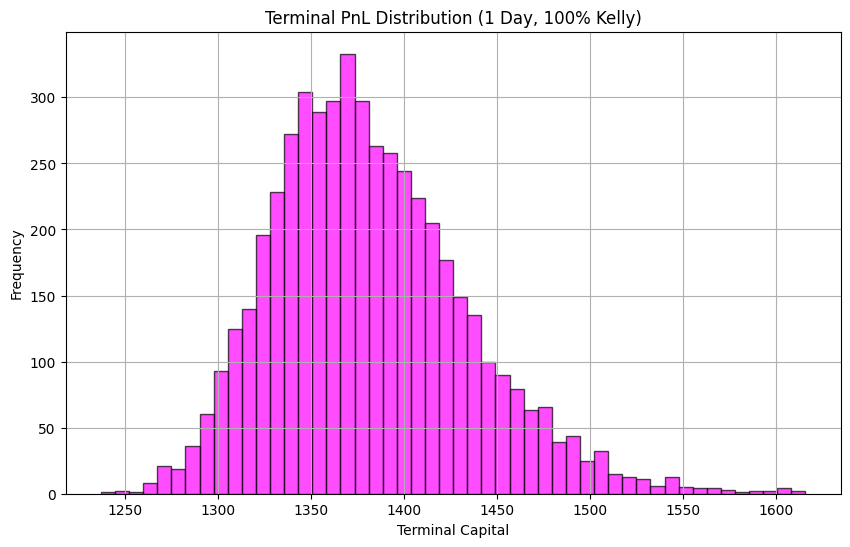

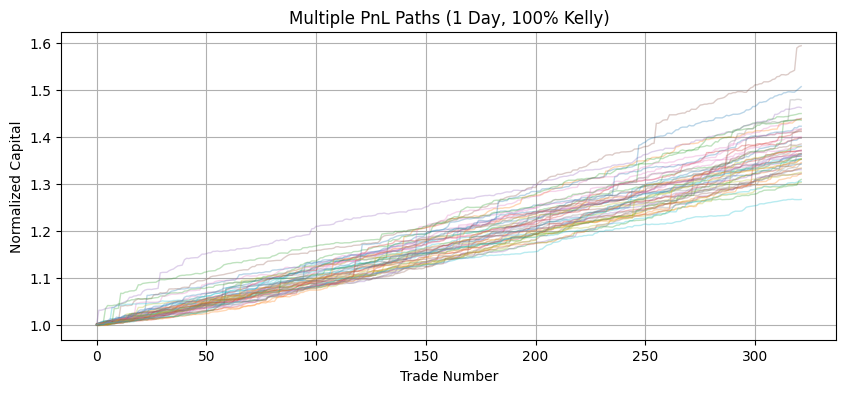


Kelly Fraction: 50%
count   5000.00
mean    1175.39
std       22.32
min     1112.25
1%      1132.41
10%     1149.06
25%     1159.67
50%     1173.02
75%     1188.92
90%     1204.90
99%     1236.75
max     1272.22


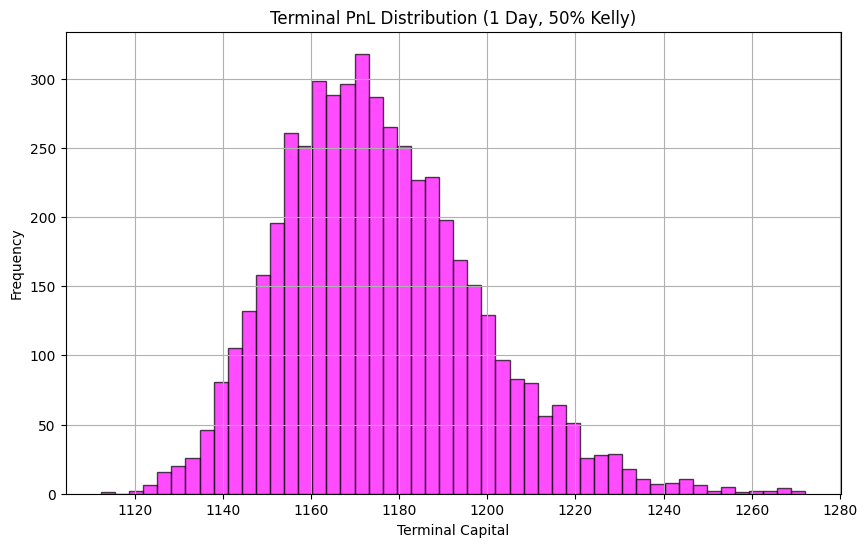

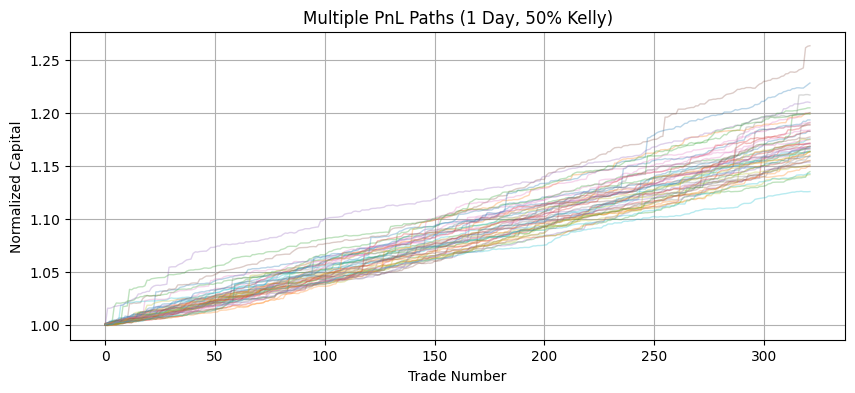


Kelly Fraction: 30%
count   5000.00
mean    1101.83
std       12.55
min     1065.92
1%      1077.49
10%     1086.96
25%     1093.00
50%     1100.54
75%     1109.49
90%     1118.43
99%     1136.13
max     1155.63


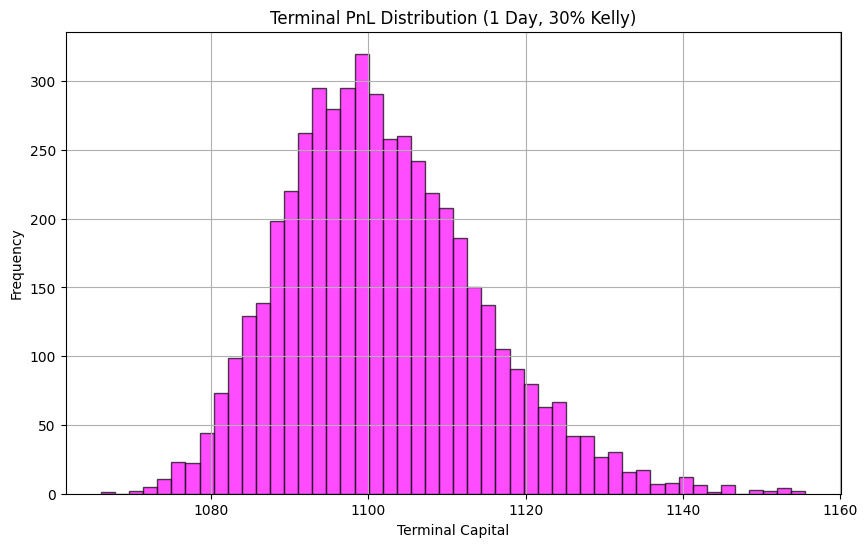

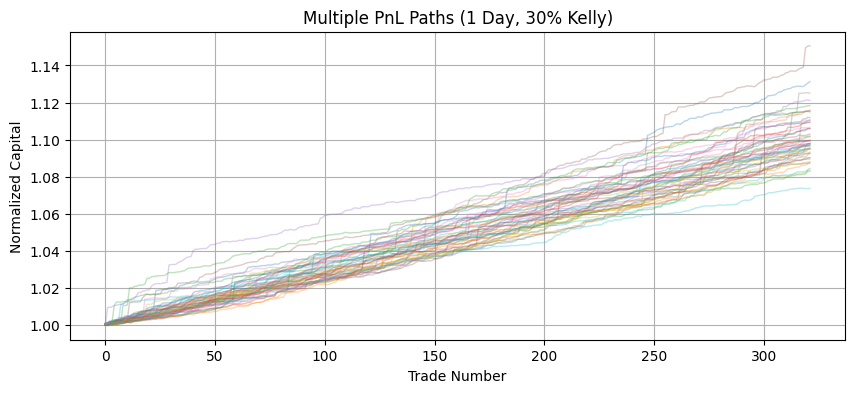


--- 3 Days Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    2980.38
std      187.29
min     2315.75
1%      2597.36
10%     2752.39
25%     2849.41
50%     2965.32
75%     3098.62
90%     3224.94
99%     3470.93
max     3868.93


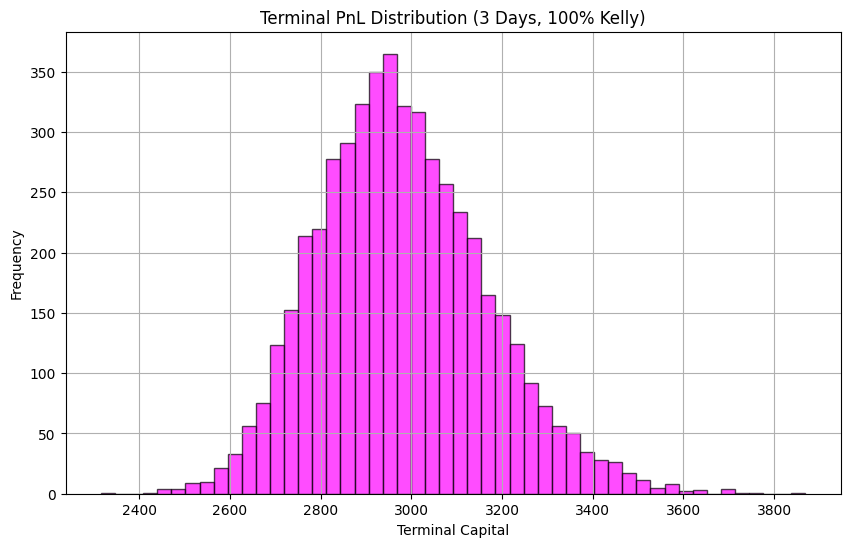

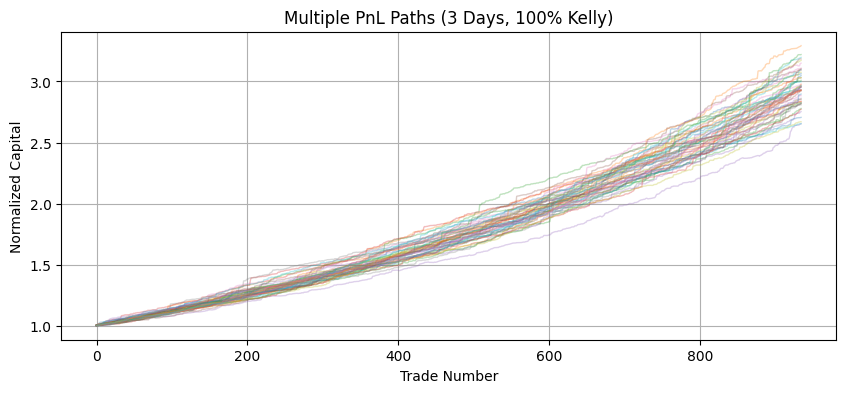


Kelly Fraction: 50%
count   5000.00
mean    1726.64
std       54.22
min     1522.19
1%      1612.28
10%     1659.96
25%     1689.00
50%     1723.10
75%     1761.60
90%     1797.13
99%     1864.75
max     1969.62


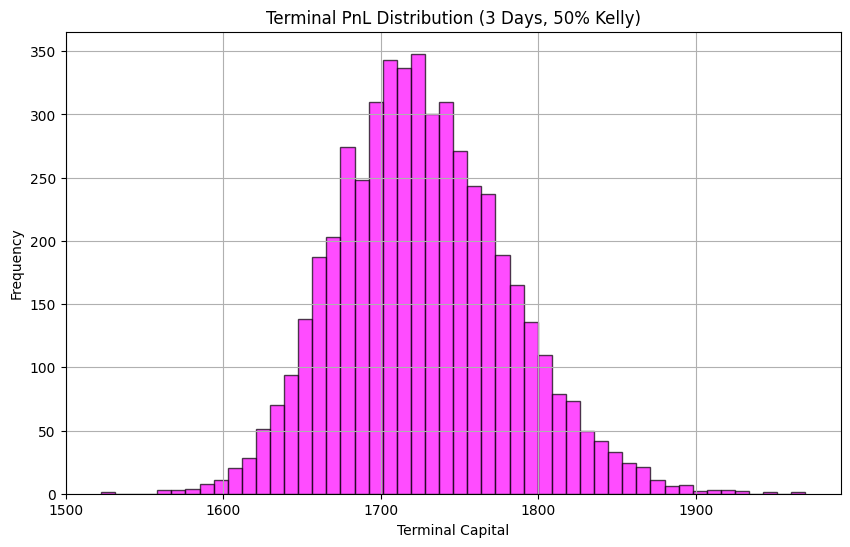

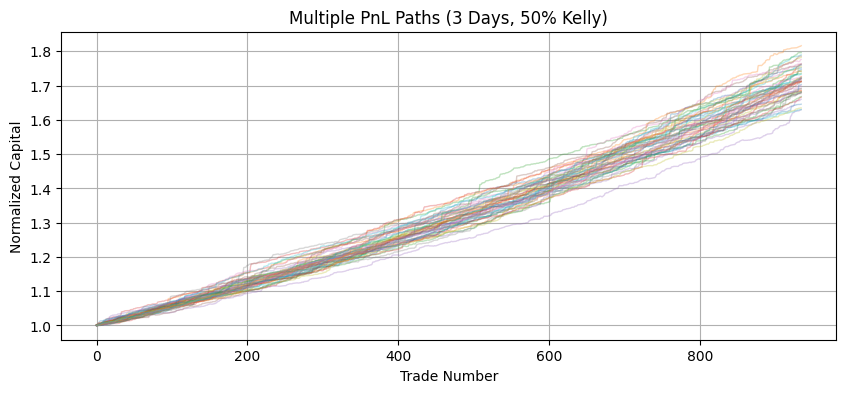


Kelly Fraction: 30%
count   5000.00
mean    1387.83
std       26.15
min     1286.80
1%      1332.01
10%     1355.56
25%     1369.75
50%     1386.26
75%     1404.81
90%     1421.76
99%     1453.68
max     1502.35


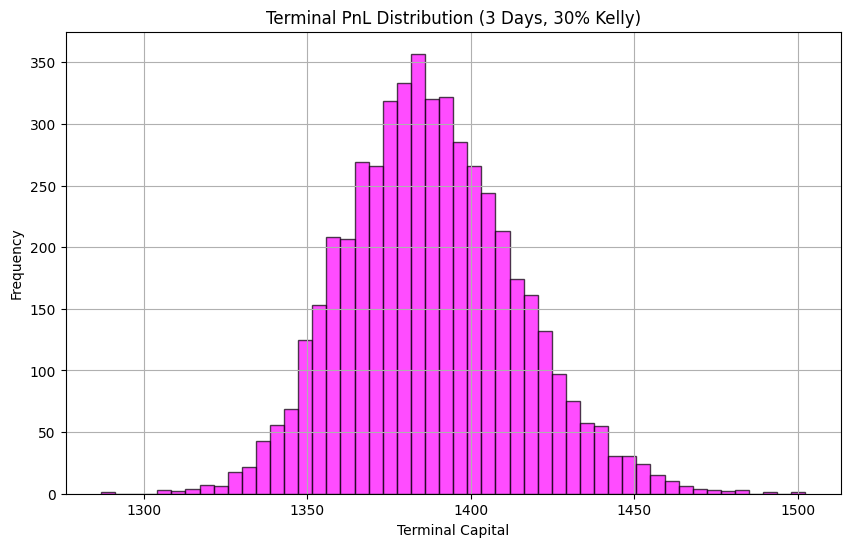

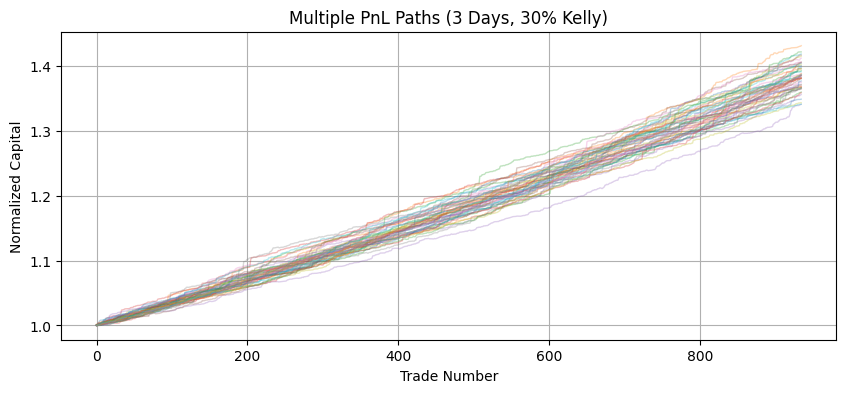


--- 1 Week Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    4843.06
std      325.07
min     3854.98
1%      4172.10
10%     4438.89
25%     4617.88
50%     4823.62
75%     5054.03
90%     5263.32
99%     5682.92
max     6171.33


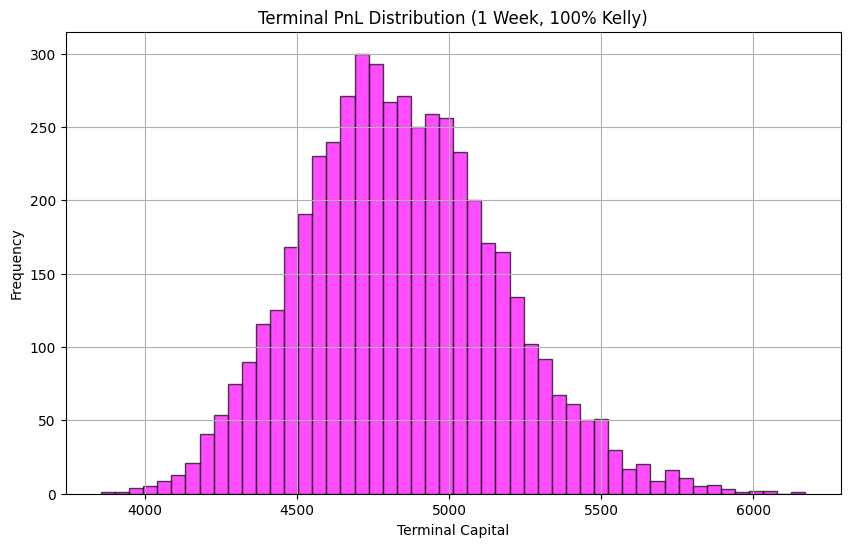

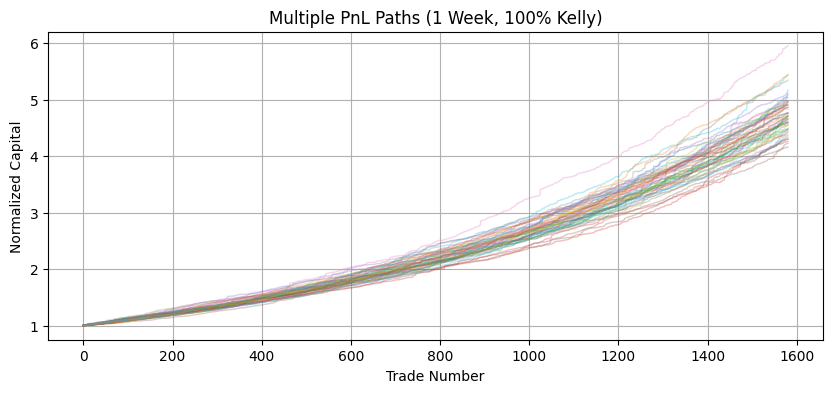


Kelly Fraction: 50%
count   5000.00
mean    2201.14
std       73.91
min     1964.36
1%      2043.71
10%     2108.39
25%     2150.37
50%     2197.84
75%     2250.12
90%     2296.15
99%     2386.36
max     2487.72


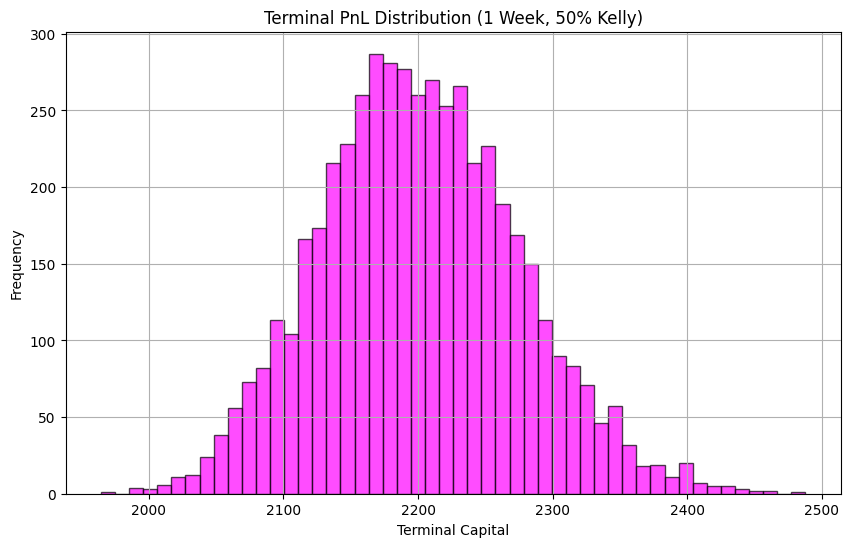

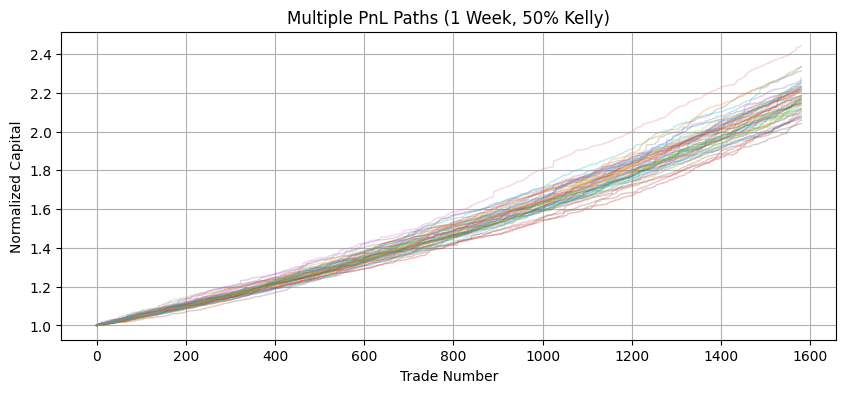


Kelly Fraction: 30%
count   5000.00
mean    1605.50
std       32.36
min     1499.63
1%      1535.71
10%     1564.72
25%     1583.35
50%     1604.26
75%     1627.05
90%     1647.01
99%     1685.60
max     1728.34


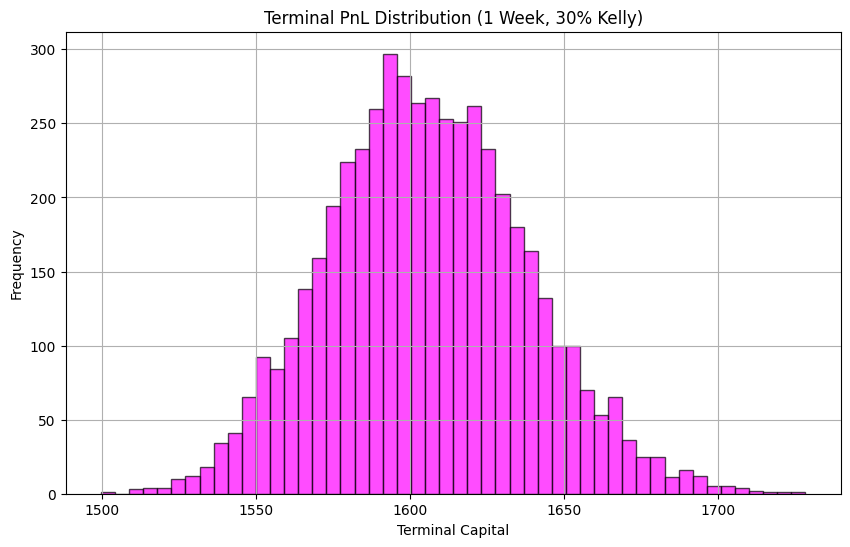

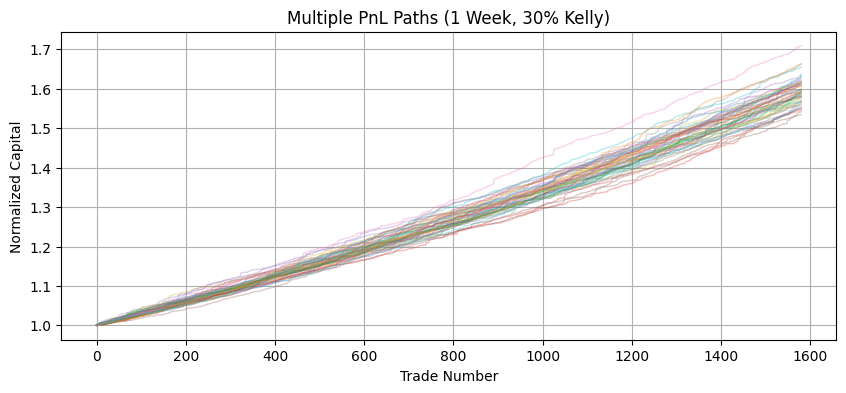


--- Full Dataset Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    4843.06
std      325.07
min     3854.98
1%      4172.10
10%     4438.89
25%     4617.88
50%     4823.62
75%     5054.03
90%     5263.32
99%     5682.92
max     6171.33


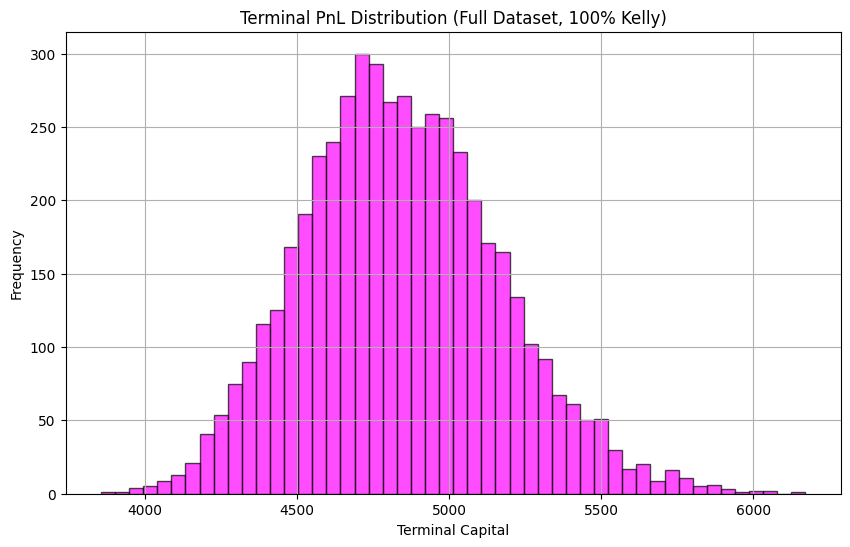

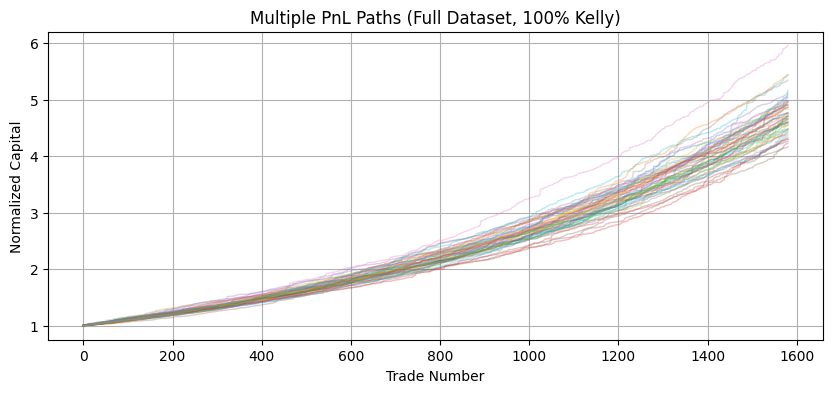


Kelly Fraction: 50%
count   5000.00
mean    2201.14
std       73.91
min     1964.36
1%      2043.71
10%     2108.39
25%     2150.37
50%     2197.84
75%     2250.12
90%     2296.15
99%     2386.36
max     2487.72


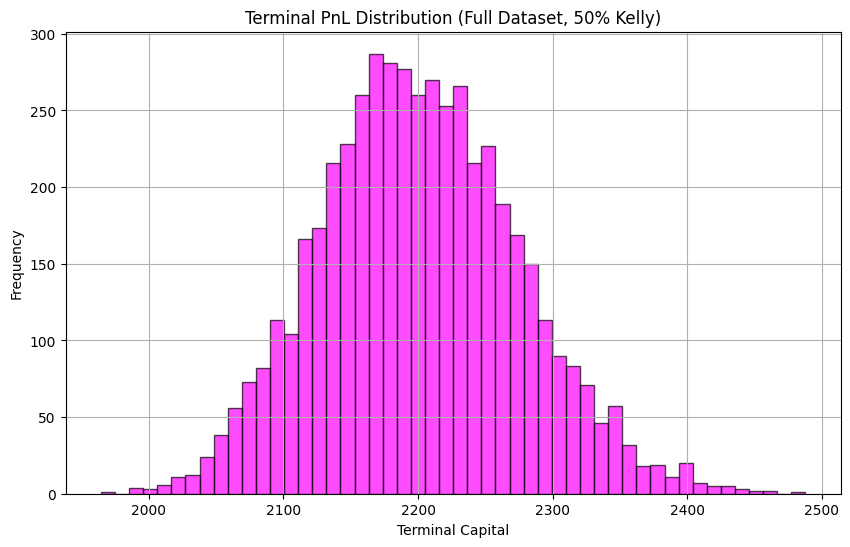

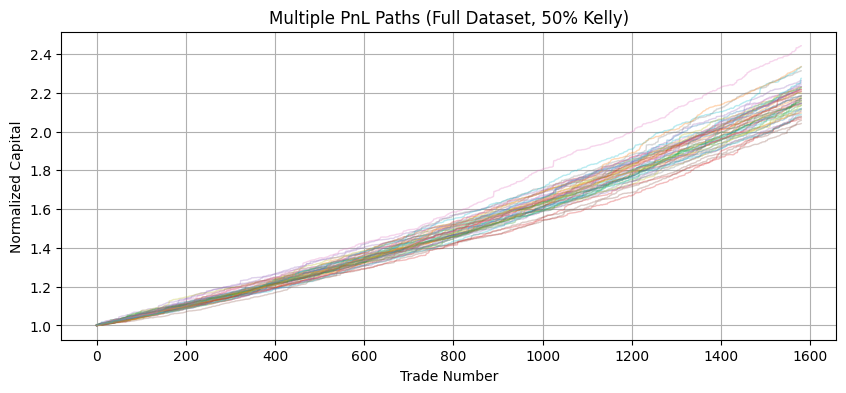


Kelly Fraction: 30%
count   5000.00
mean    1605.50
std       32.36
min     1499.63
1%      1535.71
10%     1564.72
25%     1583.35
50%     1604.26
75%     1627.05
90%     1647.01
99%     1685.60
max     1728.34


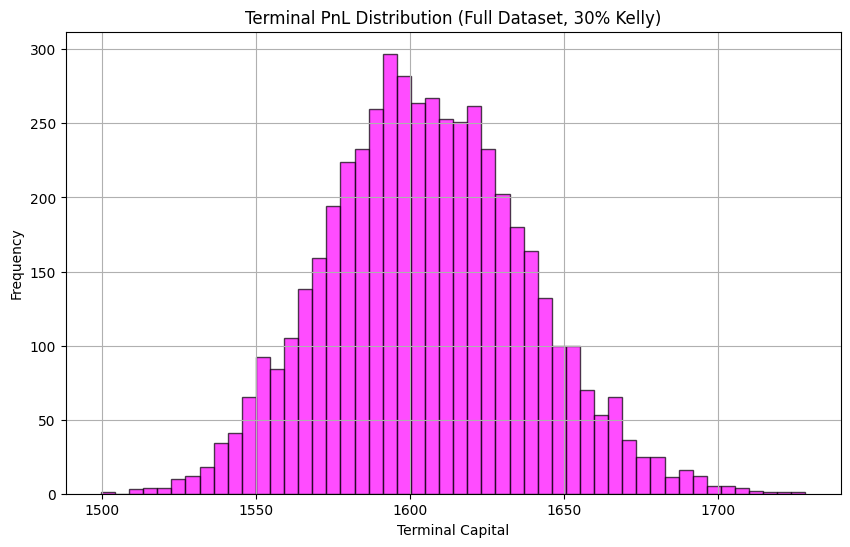

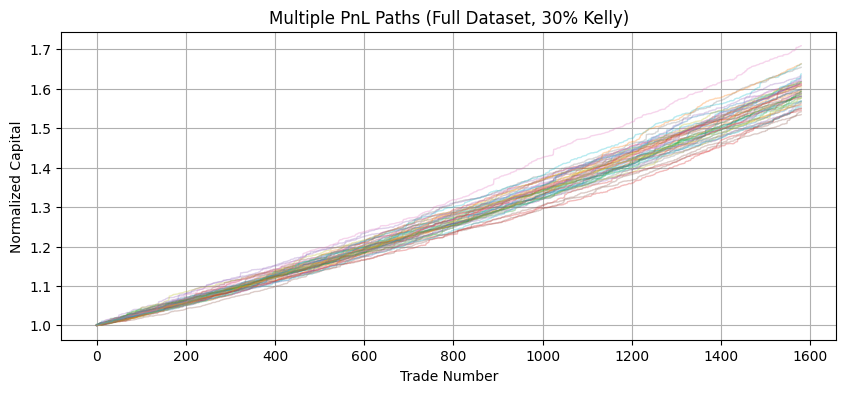

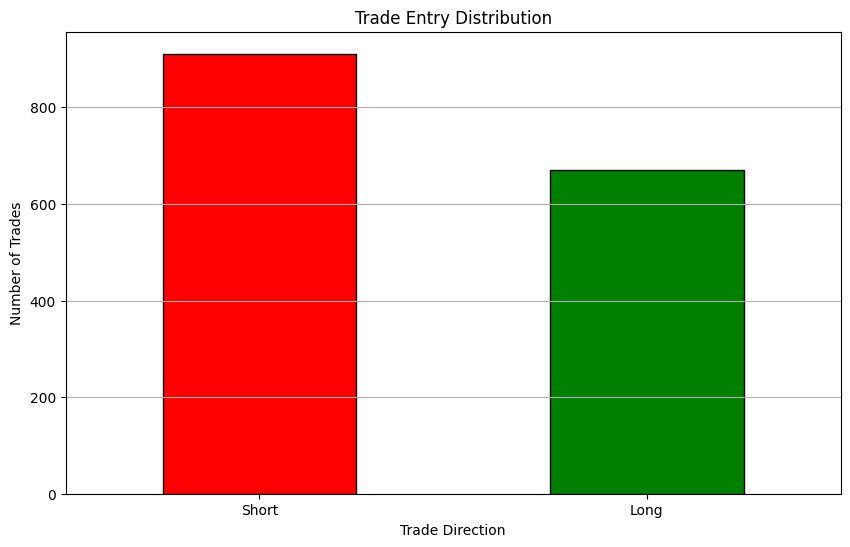

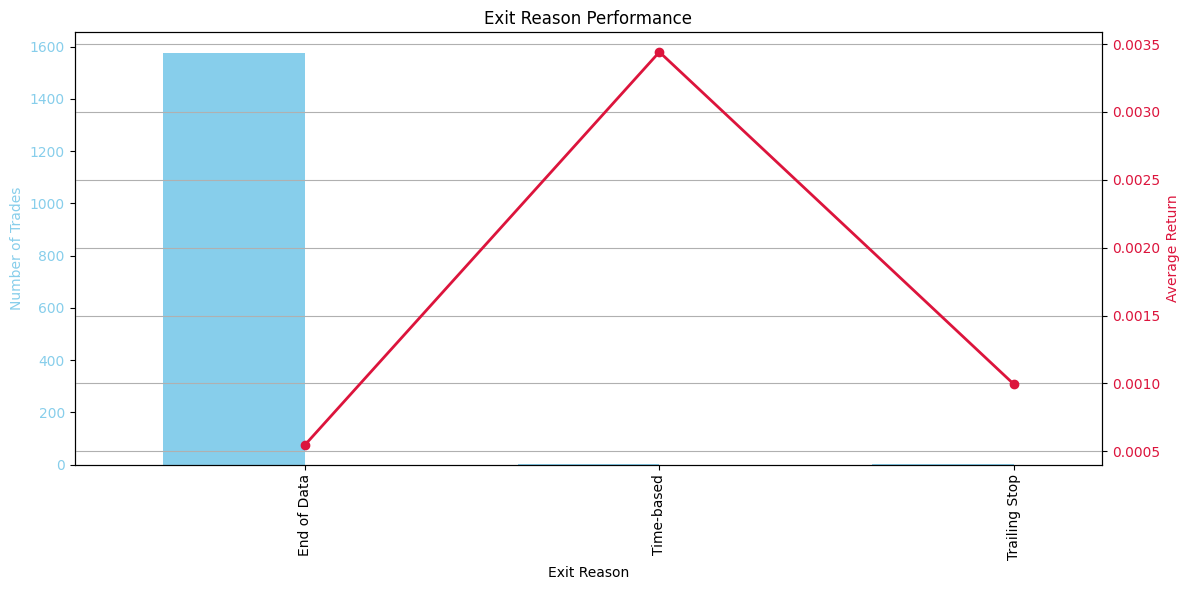


--- Trade Direction Summary ---
Direction
Short    911
Long     670

--- Exit Reason Performance ---
              Count Avg Return
Exit Reason                   
End of Data       2     0.0005
Time-based        3     0.0034
Trailing Stop  1576     0.0010

END OF REPORT


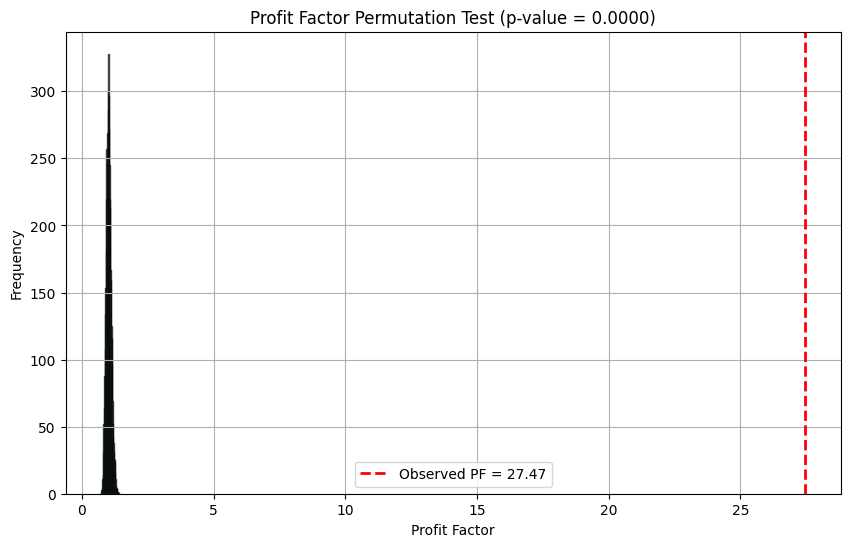


=== Profit Factor Permutation Test ===
Observed Profit Factor: 27.4687
Mean Permutation Profit Factor: 1.0049
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)

Final Profit Factor Permutation Test p-value: 0.0000


In [7]:
if not results.empty:
    generate_full_report(results)
    p_value = perform_profit_factor_permutation_test(results['Return'].values, n_permutations=5000)
    print(f"\nFinal Profit Factor Permutation Test p-value: {p_value:.4f}")
else:
    print("No trades found with the given strategy.")

In [8]:
def run_walkforward_analysis(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run walk-forward analysis of the HedgeScalp strategy
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all out-of-sample trades
    """
    # Convert dates to datetime if they're strings
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # For 7 days of data: use 5 days for training, 2 days for testing
    train_start = start_date
    train_end = start_date + timedelta(days=5)
    test_start = train_end
    test_end = end_date
    
    print(f"\n=== Processing Walk-Forward Window ===")
    print(f"Training: {train_start.date()} to {train_end.date()}")
    print(f"Testing:  {test_start.date()} to {test_end.date()}")
    
    # Start storing results
    all_oos_trades = []
    
    # Process each ticker
    for ticker in tqdm(tickers, desc="Processing Tickers"):
        try:
            data = get_historical_data(ticker, train_start - timedelta(days=1),
                                        test_end + timedelta(days=1))
            
            if data.empty:
                continue
            
            # Convert timezone-aware index to naive for comparison
            data.index = data.index.tz_localize(None)
            
            # Split into train and test sets
            train_data = data[data.index < train_end]
            test_data = data[(data.index >= test_start) & (data.index < test_end)]
            
            if train_data.empty or test_data.empty:
                continue
            
            # Apply strategy to training data (for analysis only)
            train_data = apply_strategy(train_data)
            
            # Apply strategy to the test data
            test_data = apply_strategy(test_data)
            
            # Skip if no signals were generated in test set
            if 'Signal' not in test_data.columns or test_data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day in test data
            for day, day_data in test_data.groupby(test_data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if len(active_trades) == 0 and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Stop': initial_stop,
                            'RSI': row['RSI'],
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = test_data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = test_data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall out-of-sample results
            all_oos_trades.extend(ticker_trades)
            
            # Print ticker performance summary
            if ticker_trades:
                ticker_returns = [t['Return'] for t in ticker_trades]
                total_pnl = sum(ticker_returns)
                num_trades = len(ticker_returns)
                win_rate = sum(1 for r in ticker_returns if r > 0) / num_trades if num_trades > 0 else 0
                profit_factor = calculate_profit_factor(np.array(ticker_returns))
                
                print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%}, Profit Factor: {profit_factor:.2f})")
            
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe
    if all_oos_trades:
        oos_results = pd.DataFrame(all_oos_trades)
        
        # Print overall out-of-sample performance summary
        print("\n=== Overall Out-of-Sample Performance Summary ===")
        total_return = oos_results['Return'].sum()
        avg_return = oos_results['Return'].mean()
        win_rate = (oos_results['Return'] > 0).mean()
        profit_factor = calculate_profit_factor(oos_results['Return'].values)
        
        print(f"Total Return: {total_return:.4f} ({oos_results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {avg_return:.4f} ({oos_results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Total Number of Trades: {len(oos_results)}")
        
        # Perform Monte Carlo analysis on OOS returns
        profit_factor_pvalue = perform_profit_factor_permutation_test(oos_results['Return'].values)
        
        return oos_results, profit_factor_pvalue
    else:
        print("No trades were generated in the out-of-sample period.")
        return pd.DataFrame(), None


=== Processing Walk-Forward Window ===
Training: 2025-09-10 to 2025-09-15
Testing:  2025-09-15 to 2025-09-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')


MSTR: Total PnL: 0.0410 from 37 trades (Win rate: 81.08%, Profit Factor: 135.81)
COIN: Total PnL: 0.0065 from 14 trades (Win rate: 71.43%, Profit Factor: 5.37)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

RIVN: Total PnL: 0.0498 from 48 trades (Win rate: 79.17%, Profit Factor: 16.39)




1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')


CVNA: Total PnL: 0.0122 from 21 trades (Win rate: 57.14%, Profit Factor: 35.73)
PLTR: Total PnL: 0.0065 from 8 trades (Win rate: 62.50%, Profit Factor: inf)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DJT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMD']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
Processing Tickers:  37%|███▋      | 7/19 [00:01<00:02,  4.24it/s]

DJT: Total PnL: 0.0170 from 31 trades (Win rate: 74.19%, Profit Factor: 44.19)
AMD: Total PnL: 0.0205 from 29 trades (Win rate: 79.31%, Profit Factor: inf)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

MRNA: Total PnL: 0.0805 from 35 trades (Win rate: 85.71%, Profit Factor: 60.07)




1 Failed download:
['DKNG']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
Processing Tickers:  47%|████▋     | 9/19 [00:02<00:02,  4.25it/s]

Error processing DKNG: Timestamp('2025-09-17 11:50:00')


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNAP']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
Processing Tickers:  53%|█████▎    | 10/19 [00:04<00:06,  1.37it/s]

SNAP: Total PnL: 0.0283 from 38 trades (Win rate: 68.42%, Profit Factor: 17.64)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
Processing Tickers:  58%|█████▊    | 11/19 [00:04<00:05,  1.54it/s]

MARA: Total PnL: 0.0651 from 34 trades (Win rate: 82.35%, Profit Factor: 16.40)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
Processing Tickers:  63%|██████▎   | 12/19 [00:06<00:07,  1.05s/it]

RIOT: Total PnL: 0.0416 from 26 trades (Win rate: 84.62%, Profit Factor: 29.36)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMX']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
Processing Tickers:  74%|███████▎  | 14/19 [00:12<00:08,  1.77s/it]

KMX: Total PnL: 0.0311 from 39 trades (Win rate: 82.05%, Profit Factor: inf)
CLSK: Total PnL: 0.0716 from 42 trades (Win rate: 83.33%, Profit Factor: 18.98)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CORZ']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
Processing Tickers:  79%|███████▉  | 15/19 [00:12<00:05,  1.29s/it]

CORZ: Total PnL: 0.0236 from 35 trades (Win rate: 71.43%, Profit Factor: 10.57)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HUT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CZR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:24:00 -> 2025-09-18 18:24:01.271205)')
Processing Tickers:  89%|████████▉ | 17/19 [00:13<00:01,  1.28it/s]

HUT: Total PnL: 0.0354 from 24 trades (Win rate: 66.67%, Profit Factor: 41.76)
CZR: Total PnL: 0.0217 from 38 trades (Win rate: 71.05%, Profit Factor: 134.90)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
Processing Tickers:  95%|█████████▍| 18/19 [00:14<00:01,  1.04s/it]

NVDA: Total PnL: 0.0044 from 18 trades (Win rate: 55.56%, Profit Factor: inf)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-17 13:25:00 -> 2025-09-18 18:24:01.271205) (Yahoo error = "Data doesn\'t exist for startDate = 1758129900, endDate = 1758234241")')
Processing Tickers: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


AVGO: Total PnL: 0.0072 from 18 trades (Win rate: 44.44%, Profit Factor: inf)

=== Overall Out-of-Sample Performance Summary ===
Total Return: 0.5640 (56.40%)
Average Return per Trade: 0.0011 (0.11%)
Win Rate: 74.77%
Profit Factor: 26.63
Total Number of Trades: 535


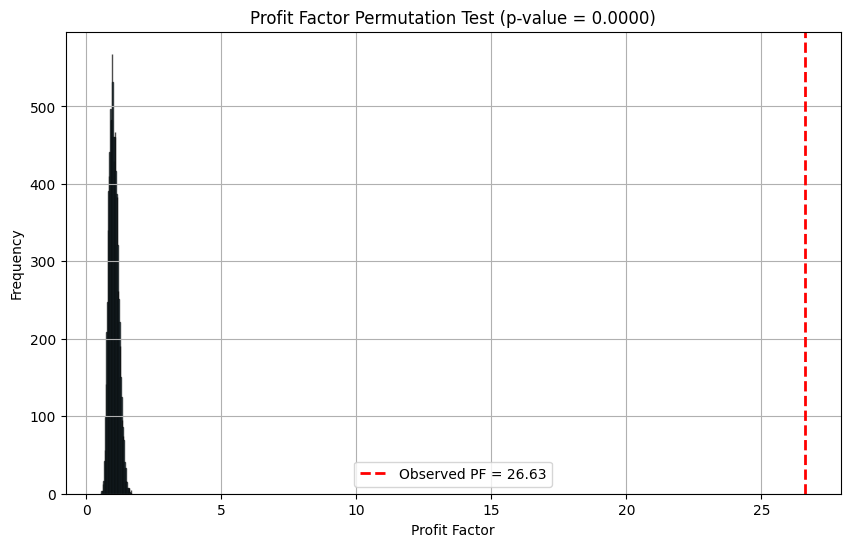


=== Profit Factor Permutation Test ===
Observed Profit Factor: 26.6315
Mean Permutation Profit Factor: 1.0155
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)


In [9]:
# Run the walk-forward analysis
oos_results, profit_factor_pvalue = run_walkforward_analysis(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=5
)